# Introduction to GAN

This notebook is meant to familiarize its users on how Generative Adversarial Network works. It is based on the implementation of GAN on this link: https://www.geeksforgeeks.org/generative-adversarial-network-gan/

In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np 
import matplotlib.pyplot as plt

We will now import the MNIST dataset.

In [2]:
mnist = input_data.read_data_sets("MNIST_data")

W0729 15:14:15.712029 139711243401024 deprecation.py:323] From <ipython-input-2-c15e4fb2cf7b>:1: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
W0729 15:14:15.712810 139711243401024 deprecation.py:323] From /home/gamma/anaconda3/lib/python3.7/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:260: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.
W0729 15:14:15.714285 139711243401024 deprecation.py:323] From /home/gamma/anaconda3/lib/python3.7/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:262: extract_images (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a futur

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz


W0729 15:14:15.945189 139711243401024 deprecation.py:323] From /home/gamma/anaconda3/lib/python3.7/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:290: DataSet.__init__ (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Creating models

This function will create the Generator model. It consists of two dense layers and an output layer.

In [3]:
def generator(z, reuse = None): 
    with tf.variable_scope('gen', reuse = reuse): 
        hidden1 = tf.layers.dense(inputs = z, units = 128,  
                            activation = tf.nn.leaky_relu) 
                              
        hidden2 = tf.layers.dense(inputs = hidden1, 
           units = 128, activation = tf.nn.leaky_relu) 
             
        output = tf.layers.dense(inputs = hidden2,  
             units = 784, activation = tf.nn.tanh) 
          
        return output

We will now create the Discriminator model. It contains two dense layers as well as a classifier.

In [4]:
def discriminator(X, reuse = None): 
    with tf.variable_scope('dis', reuse = reuse): 
        hidden1 = tf.layers.dense(inputs = X, units = 128, 
                            activation = tf.nn.leaky_relu) 
                              
        hidden2 = tf.layers.dense(inputs = hidden1, 
               units = 128, activation = tf.nn.leaky_relu) 
                 
        logits = tf.layers.dense(hidden2, units = 1) 
        output = tf.sigmoid(logits) 
          
        return output, logits 

In [5]:
tf.reset_default_graph()

## Input variables

We will create placeholders for the outputs.

In [6]:
tf.reset_default_graph() 

real_images = tf.placeholder(tf.float32, shape =[None, 784]) 
z = tf.placeholder(tf.float32, shape =[None, 100])

We will run the generator and discriminator models.

In [7]:
G = generator(z) 
D_output_real, D_logits_real = discriminator(real_images) 
D_output_fake, D_logits_fake = discriminator(G, reuse = True)

W0729 15:15:08.305019 139711243401024 deprecation.py:323] From <ipython-input-3-85d873a7af25>:4: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0729 15:15:08.309037 139711243401024 deprecation.py:506] From /home/gamma/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


## Model preparation

Loss function

In [8]:
def loss_func(logits_in, labels_in): 
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits( 
                        logits = logits_in, labels = labels_in))

In [9]:
# Smoothing for generalization 
D_real_loss = loss_func(D_logits_real, tf.ones_like(D_logits_real)*0.9) 
D_fake_loss = loss_func(D_logits_fake, tf.zeros_like(D_logits_real)) 
D_loss = D_real_loss + D_fake_loss 

G_loss = loss_func(D_logits_fake, tf.ones_like(D_logits_fake)) 

W0729 15:15:28.697840 139711243401024 deprecation.py:323] From /home/gamma/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [13]:
lr = 0.001 # learning rate
batch_size = 100 # batch size 
epochs = 10 # number of epochs. The higher the better the result 

In [11]:
tvars = tf.trainable_variables()  
d_vars =[var for var in tvars if 'dis' in var.name] 
g_vars =[var for var in tvars if 'gen' in var.name]

D_trainer = tf.train.AdamOptimizer(lr).minimize(D_loss, var_list = d_vars)
G_trainer = tf.train.AdamOptimizer(lr).minimize(G_loss, var_list = g_vars)

In [12]:
init = tf.global_variables_initializer()

## Model training

A session will be created to train the network.

In [14]:
samples = [] # generator examples 
  
with tf.Session() as sess: 
    sess.run(init) 
    for epoch in range(epochs): 
        num_batches = mnist.train.num_examples//batch_size 
          
        for i in range(num_batches): 
            batch = mnist.train.next_batch(batch_size) 
            batch_images = batch[0].reshape((batch_size, 784)) 
            batch_images = batch_images * 2-1
            batch_z = np.random.uniform(-1, 1, size =(batch_size, 100)) 
            _= sess.run(D_trainer, feed_dict ={real_images:batch_images, z:batch_z}) 
            _= sess.run(G_trainer, feed_dict ={z:batch_z}) 
              
        print("on epoch{}".format(epoch)) 
          
        sample_z = np.random.uniform(-1, 1, size =(1, 100)) 
        gen_sample = sess.run(generator(z, reuse = True), 
                                 feed_dict ={z:sample_z}) 
          
        samples.append(gen_sample)

on epoch0
on epoch1
on epoch2
on epoch3
on epoch4
on epoch5
on epoch6
on epoch7
on epoch8
on epoch9


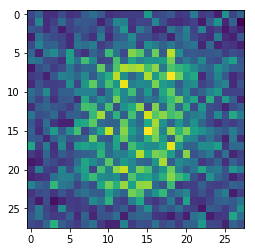

In [15]:
plt.imshow(samples[0].reshape(28, 28))

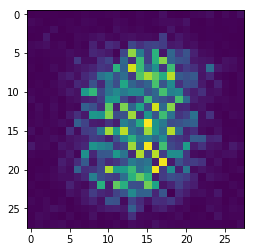

In [16]:
plt.imshow(samples[9].reshape(28, 28))